In [1]:
import pandas as pd
import numpy as np                 # to use numpy arrays
import keras
import matplotlib.pyplot as plt
import pandas as pd
import warnings
# warnings.filterwarnings('ignore')

# Load country boundaries from Natural Earth


/Users/tamhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Clean data

# you can change your path here, dont delete my path *****(>"<)******

In [2]:
import pandas as pd
import os
root_path = "/Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/"
data_path = root_path + "data/"
result_path = root_path + "result/"
df = pd.read_csv(data_path + "panel data.csv", na_values="NA")
pop = pd.read_csv(data_path + "pop.csv")
neighbor_df = pd.read_csv(data_path + 'dist_cepii.csv')
im_ex_df = pd.read_csv(data_path+'im_ex.csv')
polity_df = pd.read_csv(data_path + 'polity.csv')

/var/folders/mx/hlbqk62j2bg7n9m4xw5mmywh0000gn/T/ipykernel_26420/2274513398.py:10: DtypeWarning: Columns (11,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  polity_df = pd.read_csv(data_path + 'polity.csv')


In [3]:
# Rename polity_df.scode -> iso3st
polity_df = polity_df.rename(columns={"scode": "iso3st"})

# Merge on iso3st and year
df = df.merge(
    polity_df[["iso3st", "year", "polity2"]],
    on=["iso3st", "year"],
    how="left"
)


In [4]:
# Unique ISO3 country codes in both datasets
iso_df = set(df['iso3st'].unique())
iso_imex = set(im_ex_df['iso3st'].unique())

# Countries in df but not in im_ex_df
missing_in_imex = iso_df - iso_imex

# Countries in im_ex_df but not in df
missing_in_df = iso_imex - iso_df

print("✅ Countries in both datasets:", len(iso_df & iso_imex))
print("❌ Countries in df but not in im_ex_df:", missing_in_imex)
print("❌ Countries in im_ex_df but not in df:", missing_in_df)


✅ Countries in both datasets: 210
❌ Countries in df but not in im_ex_df: set()
❌ Countries in im_ex_df but not in df: {'ECA', nan, 'IDX', 'LAC', 'ARB', 'AFE', 'LCN', 'TMN', 'CSS', 'DEU', 'HIC', 'USA', 'PST', 'MNA', 'HPC', 'OED', 'TSS', 'EUU', 'IBT', 'INX', 'SSF', 'SSA', 'LMY', 'FCS', 'EAP', 'IDA', 'LTE', 'WLD', 'EAS', 'LIC', 'SST', 'NAC', 'IBD', 'GBR', 'CAN', 'TSA', 'LDC', 'CEB', 'AFW', 'EAR', 'TLA', 'TEC', 'MIC', 'PSS', 'TEA', 'EMU', 'LMC', 'JPN', 'OSS', 'FRA', 'ECS', 'IDB', 'SAS', 'MEA', 'UMC', 'PRE', 'ITA'}


In [5]:
# 1. Drop aggregates (non-country codes) from im_ex_df
valid_iso = set(df['iso3st'].unique())   # real countries in df
im_ex_df = im_ex_df[im_ex_df['iso3st'].isin(valid_iso)]

# 2. Merge by iso3st and year
df = df.merge(
    im_ex_df,
    on=['iso3st', 'year'],
    how='left'
)




In [6]:
import pandas as pd

# Assuming df is your dataframe

# 1. List of sanctioning entities and sanction types
senders = ["USA", "GBR", "DEU", "FRA", "ITA", "CAN", "JPN", "EU"]
types = ["TRADE", "ARMS", "MILITARY", "FINANCIAL", "TRAVEL"]

# 2. Any sanction from any sender (overall)
df["sanction"] = df[[f"{s}_{t}" for s in senders for t in types]].max(axis=1)

# 3. Type-specific sanctions (if any sender imposed that type). Each one shows whether any sanction of that type was imposed by at least one sender.
for t in types:
    cols = [f"{s}_{t}" for s in senders]
    df[t.lower() + '_sanction'] = df[cols].max(axis=1)


# 4. Sender-specific sanctions (if that sender imposed any type). Each column tells whether the sender imposed any kind of sanction in that year.
for s in senders:
    cols = [f"{s}_{t}" for t in types]
    df[f"{s}_sanction"] = df[cols].max(axis=1)


# Check missing

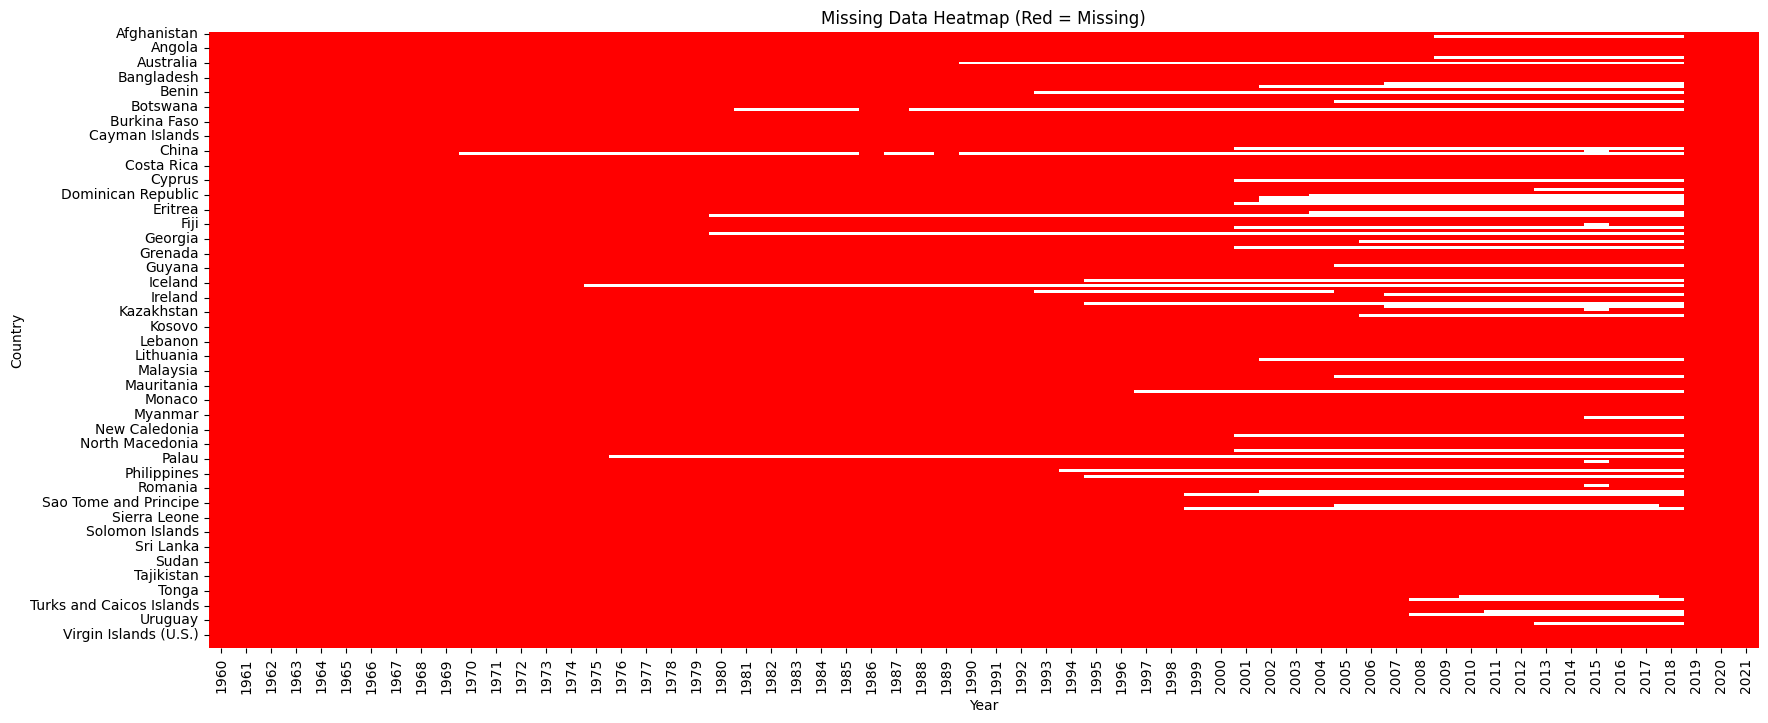

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Boolean matrix: True if any column is missing
missing_matrix = df.set_index(['Country Name','year']).isnull().any(axis=1).unstack(level=0)

# Step 2: Fill NaN with False, then convert to int
missing_matrix = missing_matrix.fillna(False).astype(int)

# Step 3: Plot heatmap
plt.figure(figsize=(20,8))
sns.heatmap(missing_matrix.T, cmap=['white','red'], cbar=False)
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('Missing Data Heatmap (Red = Missing)')
plt.show()


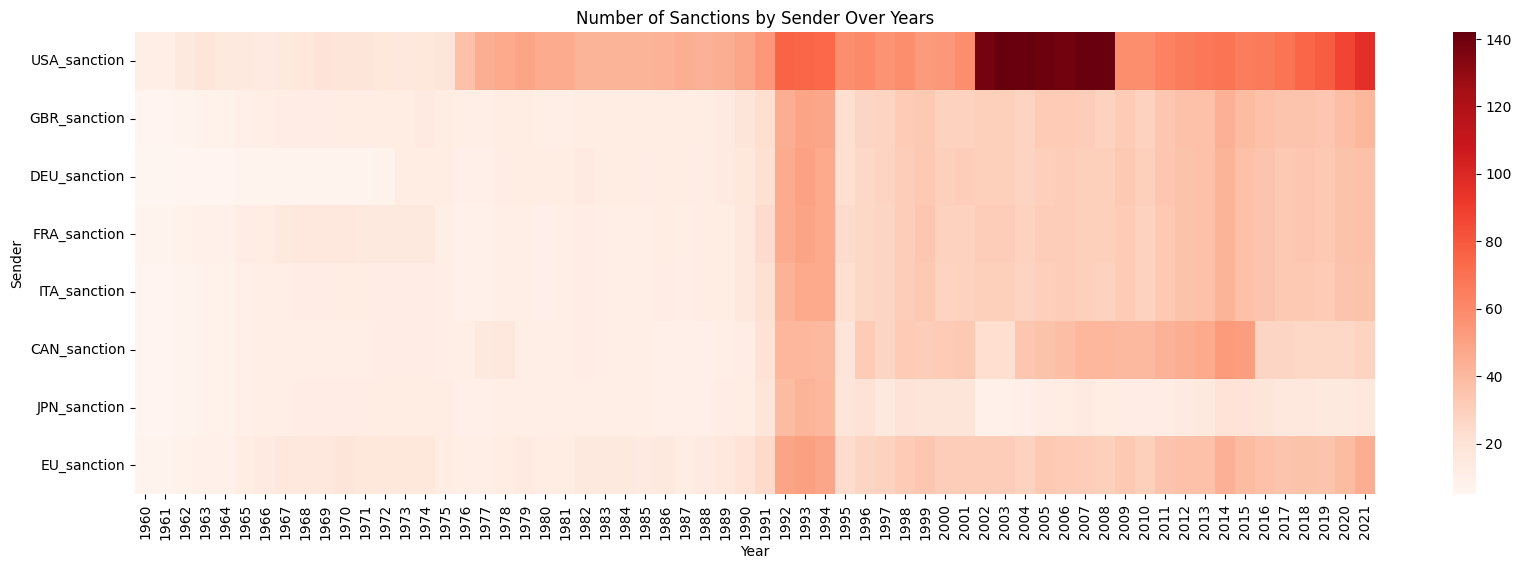

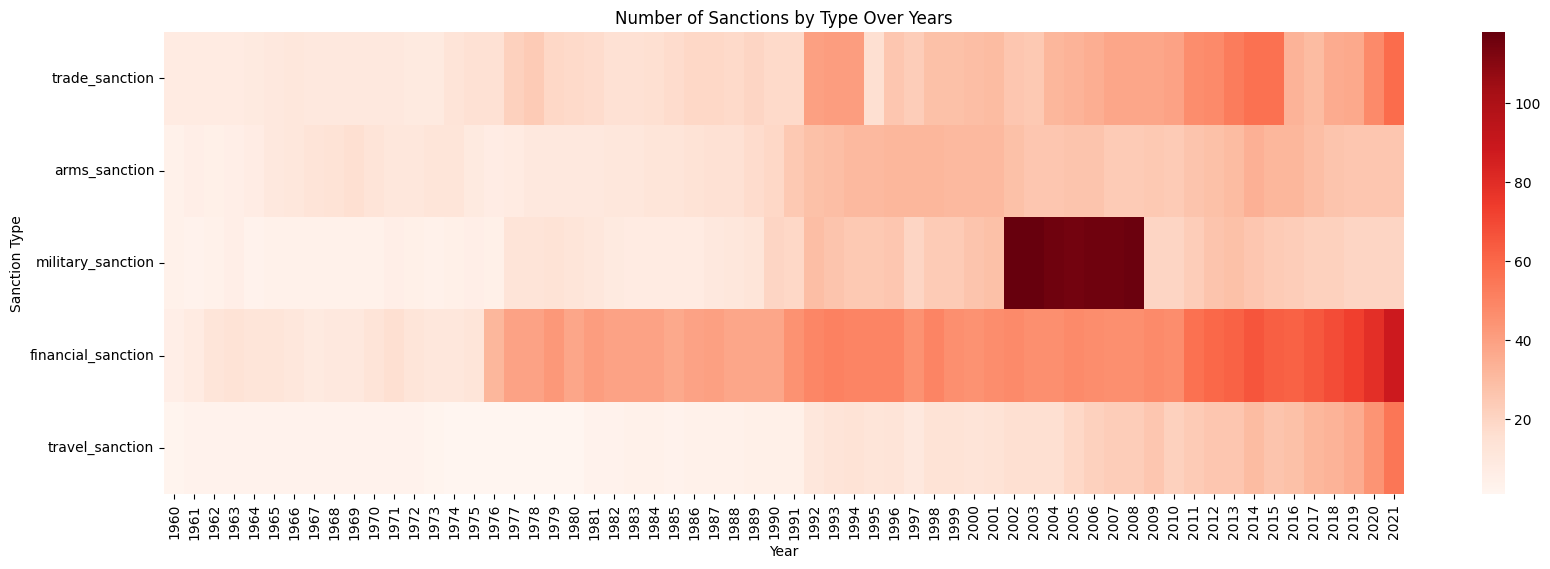

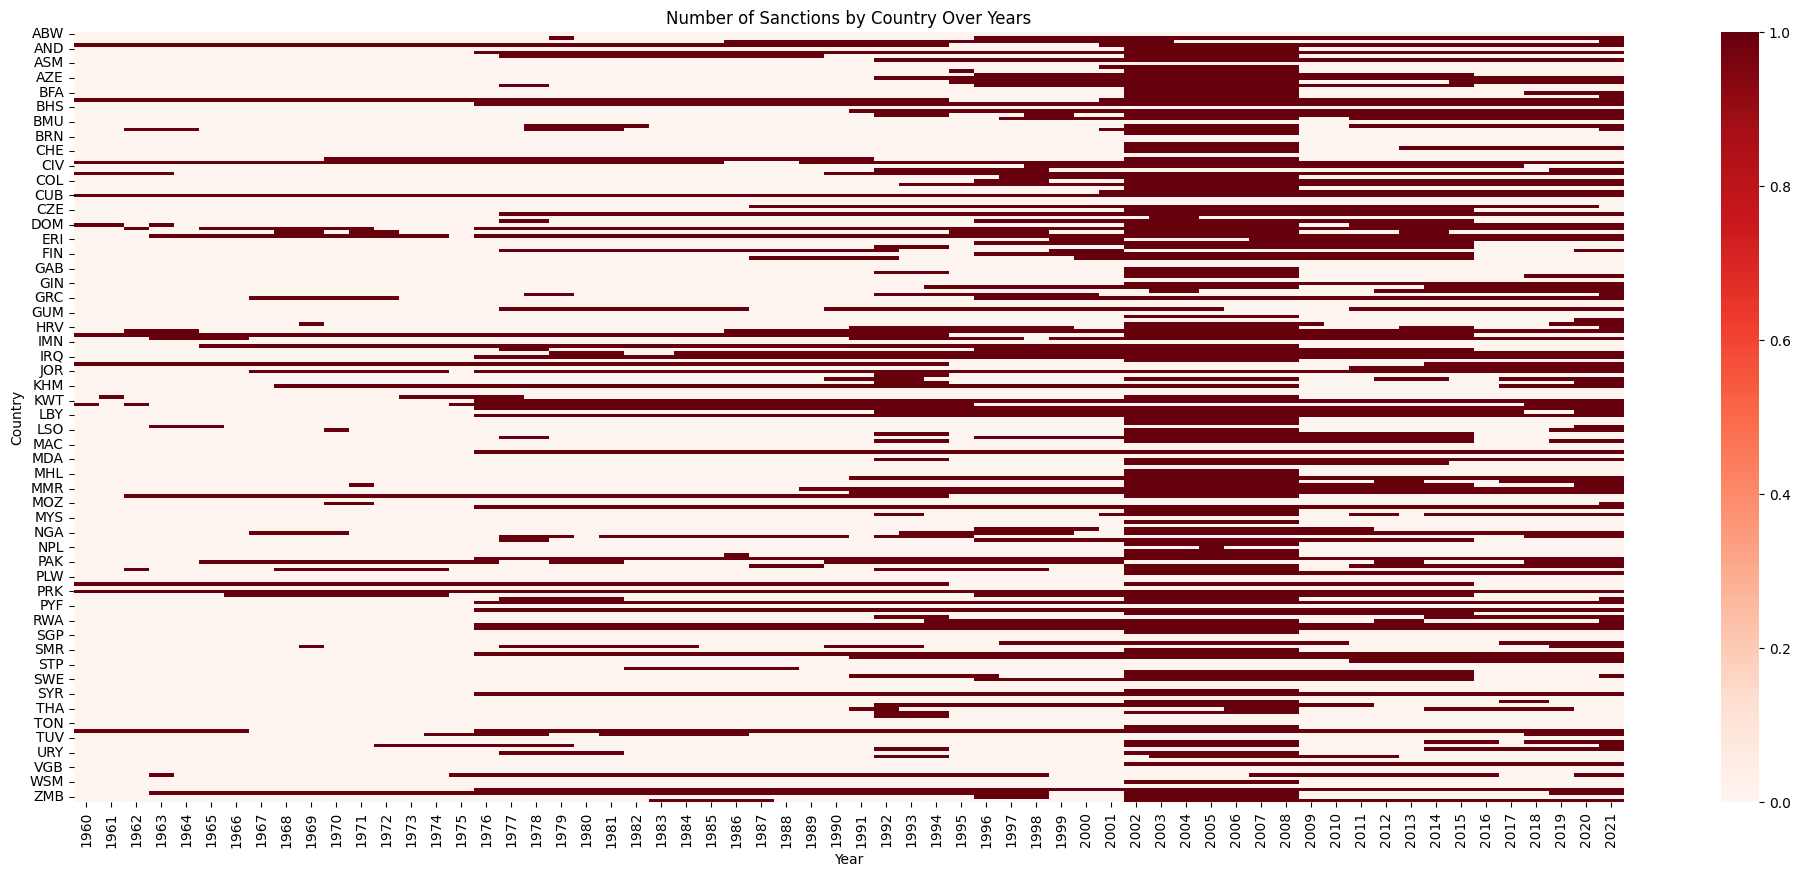

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Step 1: Define sender and type columns ---
sender_cols = ['USA_sanction','GBR_sanction','DEU_sanction','FRA_sanction',
               'ITA_sanction','CAN_sanction','JPN_sanction','EU_sanction']

type_cols = ['trade_sanction','arms_sanction','military_sanction',
             'financial_sanction','travel_sanction']

# --- Step 2: Aggregate counts per year ---
# Frequency by sender
freq_sender = df.groupby('year')[sender_cols].sum()

# Frequency by type
freq_type = df.groupby('year')[type_cols].sum()

# Frequency by country (count number of sanctions per country-year)
freq_country = df.groupby(['year','iso3st'])['sanction'].sum().unstack(fill_value=0)

# --- Step 3: Plot heatmap by sender ---
plt.figure(figsize=(20,6))
sns.heatmap(freq_sender.T, cmap='Reds', annot=False)
plt.xlabel('Year')
plt.ylabel('Sender')
plt.title('Number of Sanctions by Sender Over Years')
plt.show()

# --- Step 4: Plot heatmap by type ---
plt.figure(figsize=(20,6))
sns.heatmap(freq_type.T, cmap='Reds', annot=False)
plt.xlabel('Year')
plt.ylabel('Sanction Type')
plt.title('Number of Sanctions by Type Over Years')
plt.show()

# --- Step 5: Plot heatmap by country ---
plt.figure(figsize=(25,10))
sns.heatmap(freq_country.T, cmap='Reds', cbar=True)
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('Number of Sanctions by Country Over Years')
plt.show()


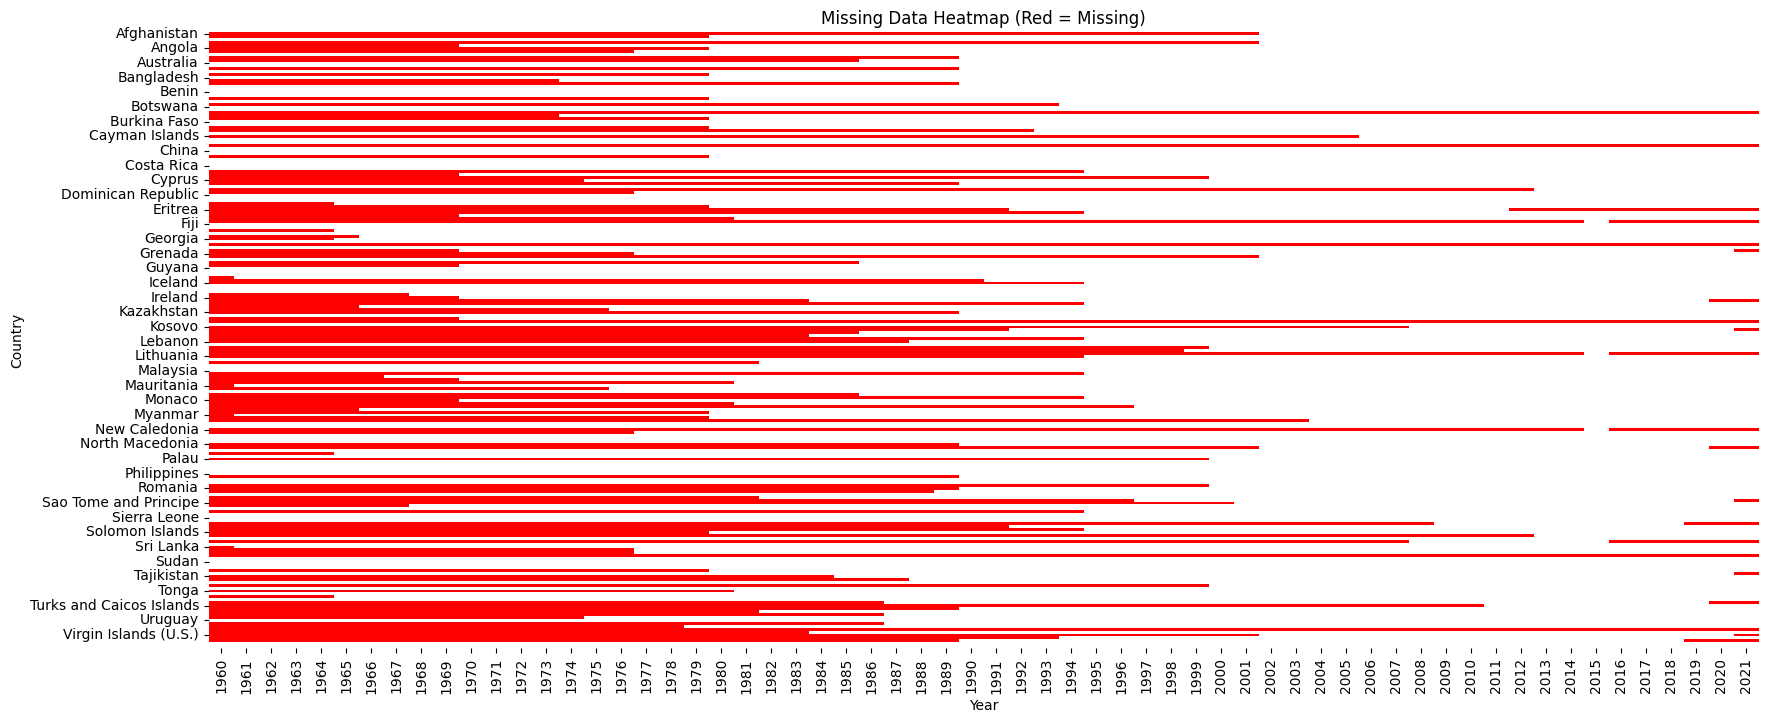

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Boolean matrix: True if any column is missing
missing_matrix = df[['Country Name','year','rgdp_t']].set_index(['Country Name','year']).isnull().any(axis=1).unstack(level=0)

# Step 2: Fill NaN with False, then convert to int
missing_matrix = missing_matrix.fillna(False).astype(int)

# Step 3: Plot heatmap
plt.figure(figsize=(20,8))
sns.heatmap(missing_matrix.T, cmap=['white','red'], cbar=False)
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('Missing Data Heatmap (Red = Missing)')
plt.show()

#  Generete Neighbor dummy

In [10]:
import pandas as pd

# Step 1: Create neighbor dummy which is 1 if they are contigeous

# ✅ Keep only land neighbors
neighbor_df = neighbor_df[neighbor_df['contig'] == 1]
# neighbor_df = neighbor_df[(neighbor_df['contig'] == 1) & (neighbor_df['comlang_off'] == 1)]

# Step 1: Expand neighbor_df to cover all years
years = df['year'].unique()
neighbor_expanded = neighbor_df.assign(key=1).merge(
    pd.DataFrame({'year': years, 'key': 1}), on='key'
).drop(columns='key')

# Step 2: Match neighbor sanctions (iso_d ↔ iso3st)
neighbor_with_sanction = neighbor_expanded.merge(
    df[['iso3st', 'year', 'sanction']],
    left_on=['iso_d', 'year'],
    right_on=['iso3st', 'year'],
    how='left'
)

# Step 3: Aggregate by origin country (iso_o)
neighbor_status = (
    neighbor_with_sanction.groupby(['iso_o', 'year'])['sanction']
    .max()
    .reset_index()
    .rename(columns={'iso_o': 'iso3st', 'sanction': 'neighbor'})
)

# Step 4: Merge back to main panel (iso3st ↔ iso_o)
df = df.merge(neighbor_status, on=['iso3st', 'year'], how='left')

# Step 5: Countries with no neighbors → set to 0
df['neighbor'] = df['neighbor'].fillna(0).astype(int)



In [11]:
# def neighbor_status(df, neighbor_df, col, new_col):
#     years = df['year'].unique()
#     expanded = neighbor_df.assign(key=1).merge(
#         pd.DataFrame({'year': years, 'key': 1}), on='key'
#     ).drop(columns='key')
#     with_sanction = expanded.merge(
#         df[['iso3st', 'year', 'sanction']],
#         left_on=['iso_d', 'year'],
#         right_on=['iso3st', 'year'],
#         how='left'
#     )
#     status = (
#         with_sanction.groupby(['iso_o', 'year'])['sanction']
#         .max()
#         .reset_index()
#         .rename(columns={'iso_o': 'iso3st', 'sanction': new_col})
#     )
#     return df.merge(status, on=['iso3st', 'year'], how='left') \
#              .assign(**{new_col: lambda x: x[new_col].fillna(0).astype(int)})

# # Apply to both
# df = neighbor_status(df, neighbor_df[neighbor_df['contig'] == 1], 'contig', 'contig_n')
# df = neighbor_status(df, neighbor_df[neighbor_df['comlang_off'] == 1], 'comlang_off', 'comlang_n')




In [12]:
import pandas as pd

# List of sender sanction columns in your df
senders = [
    'USA_sanction', 'GBR_sanction', 'DEU_sanction', 'FRA_sanction',
    'ITA_sanction', 'CAN_sanction', 'JPN_sanction', 'EU_sanction'
]

# ✅ Keep only land neighbors
neighbor_df = neighbor_df[neighbor_df['contig'] == 1]

# Step 1: Expand neighbor_df to cover all years
years = df['year'].unique()
neighbor_expanded = neighbor_df.assign(key=1).merge(
    pd.DataFrame({'year': years, 'key': 1}), on='key'
).drop(columns='key')

# Step 2: For each sender → build neighbor dummy
for sender in senders:
    # Merge in sanctions of neighbors
    tmp = neighbor_expanded.merge(
        df[['iso3st', 'year', sender]],
        left_on=['iso_d', 'year'],
        right_on=['iso3st', 'year'],
        how='left'
    )

    # Aggregate: if ANY neighbor has sanction=1 → mark 1
    tmp_status = (
        tmp.groupby(['iso_o', 'year'])[sender]
        .max()
        .reset_index()
        .rename(columns={'iso_o': 'iso3st', sender: f'neighbor_{sender}'})
    )

    # Merge back into df
    df = df.merge(tmp_status, on=['iso3st', 'year'], how='left')

# Step 3: Fill NA with 0
neighbor_cols = [f'neighbor_{s}' for s in senders]
df[neighbor_cols] = df[neighbor_cols].fillna(0).astype(int)


In [13]:
import pandas as pd

# List of sanction types
types = [
    'trade_sanction',
    'arms_sanction',
    'military_sanction',
    'financial_sanction',
    'travel_sanction',
]

# ✅ Keep only land neighbors
neighbor_df = neighbor_df[neighbor_df['contig'] == 1]

# Step 1: Expand neighbor_df to cover all years
years = df['year'].unique()
neighbor_expanded = neighbor_df.assign(key=1).merge(
    pd.DataFrame({'year': years, 'key': 1}), on='key'
).drop(columns='key')

# Step 2: For each sanction type → build neighbor dummy
for ty in types:
    tmp = neighbor_expanded.merge(
        df[['iso3st', 'year', ty]],
        left_on=['iso_d', 'year'],
        right_on=['iso3st', 'year'],
        how='left'
    )

    tmp_status = (
        tmp.groupby(['iso_o', 'year'])[ty]
        .max()
        .reset_index()
        .rename(columns={'iso_o': 'iso3st', ty: f'neighbor_{ty}'})
    )

    df = df.merge(tmp_status, on=['iso3st', 'year'], how='left')

# Step 3: Fill NA with 0
neighbor_cols = [f'neighbor_{s}' for s in types]
df[neighbor_cols] = df[neighbor_cols].fillna(0).astype(int)


# Remove missing

In [14]:
# Keep only years 1990–2021 to keep as many observation as possible
df_period = df[(df['year'] >= 1975) & (df['year'] <= 2021)]

# Drop any row with missing value in this period
df_sanction = df_period[['iso3st','Country Name','year','polity2', 'neighbor',"imports/ GDP", "imports", "exports", "exports/GDP", 'region_t', 
                         'incomegroup_t',"rgdp_t", "gdppc_t", "pop_t",'sanction','trade_sanction',
       'arms_sanction', 'military_sanction', 'financial_sanction',
       'travel_sanction', 'USA_sanction', 'GBR_sanction', 'DEU_sanction',
       'FRA_sanction', 'ITA_sanction', 'CAN_sanction', 'JPN_sanction',
       'EU_sanction','neighbor_USA_sanction',
       'neighbor_GBR_sanction', 'neighbor_DEU_sanction',
       'neighbor_FRA_sanction', 'neighbor_ITA_sanction',
       'neighbor_CAN_sanction', 'neighbor_JPN_sanction',
       'neighbor_EU_sanction',
       'neighbor_trade_sanction', 'neighbor_arms_sanction',
       'neighbor_military_sanction', 'neighbor_financial_sanction',
       'neighbor_travel_sanction'
                         ]].dropna()

# Optional: check how many rows remain
print("Rows remaining after dropping missing:", df_sanction.shape[0])


Rows remaining after dropping missing: 2609


In [15]:
#Checking before split data
# Count number of observations per country
obs_per_country = df_sanction.groupby("Country Name").size().reset_index(name="n_obs")

# Count how many years under sanction
sanction_years = df_sanction.groupby("Country Name")["sanction"].sum().reset_index(name="sanction_years")

# Merge summaries
country_summary = obs_per_country.merge(sanction_years, on="Country Name")

# Also check the time span (first and last year of data per country)
year_range = df_sanction.groupby("Country Name")["year"].agg(["min", "max"]).reset_index()
country_summary = country_summary.merge(year_range, on="Country Name")


# Show all rows without truncation
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print(country_summary)

            Country Name  n_obs  sanction_years   min   max
0            Afghanistan     17              17  2002  2018
1                Albania     39              33  1980  2018
2              Argentina     44              20  1975  2018
3                Armenia     28              27  1991  2018
4              Australia     44               8  1975  2018
5             Azerbaijan     28              27  1991  2018
6                Belarus     28              22  1991  2018
7                Belgium     44              22  1975  2018
8                  Benin     44               7  1975  2018
9                Bolivia     44              20  1975  2018
10                Brazil     44              12  1975  2018
11                 Chile     44              24  1975  2018
12                 China     44              41  1975  2018
13              Colombia     44              20  1975  2018
14               Comoros     39              26  1980  2018
15                  Cuba     44         

In [16]:
# Remove country with n_obs of observation < 5
# Keep only countries with at least 5 observations
valid_countries = country_summary.loc[country_summary["n_obs"] >= 5, "Country Name"]

# Filter the main dataset
df_sanction_filtered = df_sanction[df_sanction["Country Name"].isin(valid_countries)].copy()

print(f"Remaining countries: {df_sanction_filtered['Country Name'].nunique()}")
print(f"Remaining observations: {len(df_sanction_filtered)}")


Remaining countries: 71
Remaining observations: 2606


In [17]:
# remove missing in polity2
df_sanction = df_sanction[df_sanction["polity2"].astype(str).str.strip() != ""]


In [18]:
df_sanction['log_rgdp'] = np.log(df_sanction['rgdp_t'] + 1)
df_sanction['log_gdppc'] = np.log(df_sanction['gdppc_t'] + 1)
df_sanction['log_pop'] = np.log(df_sanction['pop_t'] + 1)



In [19]:
# Define outcome variables
trade_outcomes = ["imports/ GDP", "imports", "exports", "exports/GDP"]

# Step 1: Convert to numeric (force errors to NaN)
for col in trade_outcomes:
    df_sanction[col] = pd.to_numeric(df_sanction[col], errors="coerce")

# Step 2: Check NaN count after conversion
print("NaN count after coercion:")
print(df_sanction[trade_outcomes].isna().sum())

# Step 3: Fill NaN with 0 and convert to int
for col in trade_outcomes:
    df_sanction[col] = df_sanction[col].fillna(0).astype(int)

# Step 4: Verify
print("\nData types after cleaning:")
print(df_sanction[trade_outcomes].dtypes.head())


NaN count after coercion:
imports/ GDP    159
imports         642
exports         642
exports/GDP     159
dtype: int64

Data types after cleaning:
imports/ GDP    int64
imports         int64
exports         int64
exports/GDP     int64
dtype: object


In [20]:

df_sanction['polity2'] = pd.to_numeric(df_sanction['polity2'], errors="coerce")
import numpy as np

# Log-transform trade ratios
# Safe log transformation (handles zeros)
df_sanction["log_imports_gdp"] = np.log1p(df_sanction["imports/ GDP"])
df_sanction["log_exports_gdp"] = np.log1p(df_sanction["exports/GDP"])
df_sanction["log_imports"] = np.log1p(df_sanction["imports"])
df_sanction["log_exports"] = np.log1p(df_sanction["exports"])


In [21]:
print(df_sanction[["log_imports_gdp", "log_imports", "log_exports", "log_exports_gdp",'polity2', 'Country Name', 'region_t', 'incomegroup_t',
                   'sanction', 'neighbor', 'log_rgdp', 'log_gdppc', 'log_pop']].describe())

       log_imports_gdp  log_imports  log_exports  log_exports_gdp  \
count      2590.000000  2590.000000  2590.000000      2590.000000   
mean          3.268020    17.531718    17.426155         3.094842   
std           1.008777    10.183887    10.146615         1.036548   
min           0.000000     0.000000     0.000000         0.000000   
25%           3.091042    18.358997    17.476588         2.708050   
50%           3.433987    22.620206    22.420694         3.258097   
75%           3.850148    24.161708    24.137470         3.737670   
max           5.257495    28.324168    28.489683         5.288267   

           polity2     sanction     neighbor     log_rgdp    log_gdppc  \
count  2590.000000  2590.000000  2590.000000  2590.000000  2590.000000   
mean      2.200772     0.480309     0.721236    24.294493     8.253337   
std       7.112178     0.499709     0.448478     1.956884     1.309082   
min     -10.000000     0.000000     0.000000    19.798260     5.253499   
25%     

In [22]:
# Define outcome variables
trade_outcomes = ["imports/ GDP", "imports", "exports", "exports/GDP"]

# Step 1: Convert to numeric (force errors to NaN)
for col in trade_outcomes:
    df_sanction[col] = pd.to_numeric(df_sanction[col], errors="coerce")

# Step 2: Check NaN count after conversion
print("NaN count after coercion:")
print(df_sanction[trade_outcomes].isna().sum())

# Step 3: Fill NaN with 0 and convert to int
for col in trade_outcomes:
    df_sanction[col] = df_sanction[col].fillna(0).astype(int)

# Step 4: Verify
print("\nData types after cleaning:")
print(df_sanction[trade_outcomes].dtypes.head())


NaN count after coercion:
imports/ GDP    0
imports         0
exports         0
exports/GDP     0
dtype: int64

Data types after cleaning:
imports/ GDP    int64
imports         int64
exports         int64
exports/GDP     int64
dtype: object


In [23]:
df_sanction.columns

Index(['iso3st', 'Country Name', 'year', 'polity2', 'neighbor', 'imports/ GDP',
       'imports', 'exports', 'exports/GDP', 'region_t', 'incomegroup_t',
       'rgdp_t', 'gdppc_t', 'pop_t', 'sanction', 'trade_sanction',
       'arms_sanction', 'military_sanction', 'financial_sanction',
       'travel_sanction', 'USA_sanction', 'GBR_sanction', 'DEU_sanction',
       'FRA_sanction', 'ITA_sanction', 'CAN_sanction', 'JPN_sanction',
       'EU_sanction', 'neighbor_USA_sanction', 'neighbor_GBR_sanction',
       'neighbor_DEU_sanction', 'neighbor_FRA_sanction',
       'neighbor_ITA_sanction', 'neighbor_CAN_sanction',
       'neighbor_JPN_sanction', 'neighbor_EU_sanction',
       'neighbor_trade_sanction', 'neighbor_arms_sanction',
       'neighbor_military_sanction', 'neighbor_financial_sanction',
       'neighbor_travel_sanction', 'log_rgdp', 'log_gdppc', 'log_pop',
       'log_imports_gdp', 'log_exports_gdp', 'log_imports', 'log_exports'],
      dtype='object')

In [24]:
# Create a summary cross-tab
cross_tab = pd.crosstab(df_sanction["sanction"], df_sanction["neighbor"], normalize="all") * 100
print("\n=== Cross Distribution (Percent of Observations) ===")
print(cross_tab)



=== Cross Distribution (Percent of Observations) ===
neighbor          0          1
sanction                      
0         20.000000  31.969112
1          7.876448  40.154440


In [25]:
# Summary by country
sanction_summary = df_sanction.groupby("iso3st")["sanction"].agg(['min', 'max']).reset_index()

# Identify always-treated countries
always_treated = sanction_summary[(sanction_summary['min']==1) & (sanction_summary['max']==1)]

# Number of always-treated countries
num_always_treated = always_treated.shape[0]
print(f"Number of always-treated countries: {num_always_treated}")

# Optionally, list them
print("Always-treated countries:", always_treated['iso3st'].tolist())


Number of always-treated countries: 8
Always-treated countries: ['AFG', 'CUB', 'DJI', 'JOR', 'QAT', 'SDN', 'SOM', 'YEM']


In [26]:
import statsmodels.api as sm
df_sanction["sanction_neighbor"] = df_sanction["sanction"] * df_sanction["neighbor"]

# Define dependent variables (trade outcomes)
trade_outcomes = [ 
    # "imports", "exports",
    'log_imports', 'log_exports',

                  ]
# trade_outcomes = ["imports/ GDP", "imports", "exports", "exports/GDP"]
# Define controls (economic + polity2 + neighbor only)
# controls = ["rgdp_t", "gdppc_t", "pop_t", "polity2", "sanction",'neighbor']
controls = ["sanction", "neighbor",
            "log_rgdp",  "log_pop", "polity2"]

print("\n=== Spillover without sanction (neighbor only) ===\n")
for dep in trade_outcomes:
    y = df_sanction[dep]
    X = df_sanction[controls]

    # Drop missing values for this regression
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data[dep]
    X_clean = data[controls]

    # Add constant
    X_clean = sm.add_constant(X_clean)

    # Run OLS with robust SE
    model = sm.OLS(y_clean, X_clean).fit(cov_type="HC3")


    print(f"\nDependent var: {dep}")
    print(model.summary())


=== Spillover without sanction (neighbor only) ===


Dependent var: log_imports
                            OLS Regression Results                            
Dep. Variable:            log_imports   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     203.8
Date:                Sun, 19 Oct 2025   Prob (F-statistic):          1.43e-183
Time:                        18:45:25   Log-Likelihood:                -9330.0
No. Observations:                2590   AIC:                         1.867e+04
Df Residuals:                    2584   BIC:                         1.871e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [27]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np

# --- Create interaction term ---
df_sanction["sanction_neighbor"] = df_sanction["sanction"] * df_sanction["neighbor"]

# --- Outcome and control variables ---
trade_outcomes = ["log_imports", "log_exports"]
controls = ["sanction", "neighbor", "log_rgdp", "log_pop", "polity2"]

# --- Main loop for each dependent variable ---
print("\n=== Spillover with Country and Year Fixed Effects ===\n")

for dep in trade_outcomes:
    formula = f"{dep} ~ sanction + neighbor + log_rgdp + log_pop + polity2 + C(iso3st) + C(year)"
    
    model = smf.ols(formula=formula, data=df_sanction).fit(cov_type='HC3')
    
    print(f"\nDependent var: {dep}")
    print(model.summary())



=== Spillover with Country and Year Fixed Effects ===


Dependent var: log_imports
                            OLS Regression Results                            
Dep. Variable:            log_imports   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     524.7
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:45:25   Log-Likelihood:                -7354.5
No. Observations:                2590   AIC:                         1.495e+04
Df Residuals:                    2470   BIC:                         1.565e+04
Df Model:                         119                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

# Machine learning

In [28]:
features = ["sanction", "neighbor", "log_rgdp", "log_pop", "polity2"]

In [29]:
from sklearn.model_selection import train_test_split

# we want to split data base on country and sanction, make sure that all countries are balancedly divided, then both train and test set contain both sanctioned and not sanctioned obs.
df_sanction["strata"] = df_sanction["Country Name"] + "_" + df_sanction["sanction"].astype(str)
valid = df_sanction["strata"].value_counts() > 1

df_m = df_sanction[df_sanction["strata"].isin(valid[valid].index)]
df_s = df_sanction[~df_sanction["strata"].isin(valid[valid].index)]

tr_m, te_m = train_test_split(df_m, test_size=0.2, random_state=42, stratify=df_m["strata"])
tr_s, te_s = train_test_split(df_s, test_size=0.2, random_state=42)

train_df = pd.concat([tr_m, tr_s]).drop(columns="strata")
test_df = pd.concat([te_m, te_s]).drop(columns="strata")


In [30]:
def check_country_balance(df, name):
    summary = df.groupby("Country Name")["sanction"].agg(
        n_obs="count", n_sanction="sum"
    ).reset_index()
    print(f"\n=== {name} set summary ===")
    print(summary.sort_values("Country Name").to_string(index=False))

check_country_balance(train_df, "Train")
check_country_balance(test_df, "Test")



=== Train set summary ===
        Country Name  n_obs  n_sanction
         Afghanistan      4           4
             Albania     31          26
           Argentina     35          16
             Armenia     23          22
           Australia     35           6
          Azerbaijan     22          22
             Belarus     23          18
             Belgium     36          18
               Benin     36           6
             Bolivia     35          16
              Brazil     36          10
               Chile     35          19
               China     35          33
            Colombia     35          16
             Comoros     31          21
                Cuba     35          35
              Cyprus     36          26
             Czechia      2           0
            Djibouti      5           5
  Dominican Republic     35          12
             Ecuador     35          10
    Egypt, Arab Rep.     35          34
         El Salvador     22           2
             

In [31]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Combine all country codes from train and test
all_countries = df_sanction['iso3st'].values

# Fit the encoder on all countries
le = LabelEncoder()
le.fit(all_countries)

# Transform both train and test
train_df['country_id'] = le.transform(train_df['iso3st'])
test_df['country_id'] = le.transform(test_df['iso3st'])

# Number of unique countries
num_countries = len(le.classes_)

print("Number of countries:", num_countries)


Number of countries: 72


In [32]:
# --- Imports ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# --- Model Builder ---
def build_model(input_dim, num_countries):
    """Build a Keras model with embeddings for country."""
    # Continuous input features
    cont_input = Input(shape=(input_dim,), name="continuous_input")
    
    # Country input (categorical)
    country_input = Input(shape=(1,), name="country_input")

    # Embedding layer for country
    emb_dim = min(10, int(num_countries ** 0.25) + 1)
    country_emb = Embedding(
        input_dim=num_countries,
        output_dim=emb_dim,
        name="country_embedding"
    )(country_input)
    country_emb = Flatten()(country_emb)

    # Combine continuous + embedding
    x = Concatenate()([cont_input, country_emb])

    # Hidden layers
    x = Dense(64, activation="relu", name="dense_1")(x)
    x = Dropout(0.3, name="dropout_1")(x)
    x = Dense(32, activation="relu", name="dense_2")(x)

    # Output layer (for regression)
    output = Dense(1, activation="linear", name="output")(x)

    # Define model
    model = Model(inputs=[cont_input, country_input], outputs=output)

    # Compile
    model.compile(optimizer=Adam(0.001), loss="mse")

    return model

# --- Example usage ---
input_dim = 10         # number of continuous features
num_countries = 20     # number of unique countries

model = build_model(input_dim, num_countries)

# --- Show structure ---
print("\nModel Summary:")
model.summary()

# --- Optional: Plot structure to image ---
plot_model(
    model,
    to_file="model_structure.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)



Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ country_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_embedding   │ (None, 1, 3)      │         60 │ country_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_input    │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3)         │          0 │ country_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13)        │          0 │ continuous_input… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,069 (11.99 KB)

 Trainable params: 3,069 (11.99 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [33]:
# import numpy as np
# import pandas as pd
# import shap
# import os
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping


# # =========================================================
# # 🔧 1. Data preparation
# # =========================================================
# def prepare_data(df):
#     """Encode countries and prepare inputs for model."""
#     le = LabelEncoder()
#     df["country_id"] = le.fit_transform(df["iso3st"])
#     num_countries = len(le.classes_)
#     print("Number of countries:", num_countries)

#     features = ["sanction", "neighbor", "log_rgdp", "log_pop", "polity2"]
#     X_cont = df[features].values.astype(np.float32)
#     X_country = df["country_id"].values.astype(np.int32)
#     y = df[["log_imports", "log_exports"]].values.astype(np.float32)
#     return X_cont, X_country, y, le, num_countries, features


# # =========================================================
# # 🧠 2. Model definition
# # =========================================================
# def build_model(input_dim, num_countries):
#     """Build a Keras model with embeddings for country."""
#     cont_input = Input(shape=(input_dim,), name="continuous_input")
#     country_input = Input(shape=(1,), name="country_input")

#     emb_dim = min(10, int(num_countries ** 0.25) + 1)
#     country_emb = Embedding(input_dim=num_countries, output_dim=emb_dim, name="country_embedding")(country_input)
#     country_emb = Flatten()(country_emb)

#     x = Concatenate()([cont_input, country_emb])
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(0.3)(x)
#     x = Dense(32, activation="relu")(x)
#     output = Dense(2, activation="linear")(x)

#     model = Model(inputs=[cont_input, country_input], outputs=output)
#     model.compile(optimizer=Adam(0.001), loss="mse")
#     return model


# # =========================================================
# # ⚙️ 3. Run one fold (so you can call it individually)
# # =========================================================
# def run_fold(n, X_cont, X_country, y, num_countries, features, save_dir):
#     """Run a single fold, train model, compute SHAP, and save results."""
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     all_results = []

#     # Ensure folder exists
#     os.makedirs(save_dir, exist_ok=True)

#     # Get all folds first
#     folds = list(kf.split(X_cont, X_country))

#     # Select specific fold (1-indexed)
#     train_idx, test_idx = folds[n - 1]
#     print(f"\n🔹 Running Fold {n}")

#     # Split data
#     X_train_cont, X_test_cont = X_cont[train_idx], X_cont[test_idx]
#     X_train_country, X_test_country = X_country[train_idx], X_country[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     # --- Train model ---
#     model = build_model(X_train_cont.shape[1], num_countries)
#     es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")

#     model.fit([X_train_cont, X_train_country],
#               y_train,
#               validation_data=([X_test_cont, X_test_country], y_test),
#               epochs=100,
#               batch_size=32,
#               verbose=0,
#               callbacks=[es])

#     # --- Predict ---
#     y_pred = model.predict([X_test_cont, X_test_country], verbose=0)
#     mse_imports = np.mean((y_pred[:, 0] - y_test[:, 0]) ** 2)
#     mse_exports = np.mean((y_pred[:, 1] - y_test[:, 1]) ** 2)
#     print(f"✅ Fold {n}: MSE imports={mse_imports:.4f}, MSE exports={mse_exports:.4f}")

#     # --- SHAP for imports ---
#     def model_wrapper(x):
#         Xc, Xcty = x[:, :-1], x[:, -1].astype(int).reshape(-1, 1)
#         return model.predict([Xc, Xcty], verbose=0)[:, 0]

#     background = np.hstack([X_train_cont[:100], X_train_country[:100].reshape(-1, 1)])
#     test_input = np.hstack([X_test_cont, X_test_country.reshape(-1, 1)])

#     explainer = shap.KernelExplainer(model_wrapper, background)
#     shap_values = explainer.shap_values(test_input, nsamples=100)

#     # --- Combine with SHAP values & features ---
#     shap_cols = ["shap_" + c for c in (features + ["country_id"])]
#     df_shap = pd.DataFrame(shap_values, columns=shap_cols)

#     df_fold = pd.DataFrame({
#         "fold": n,
#         "preindex": test_idx,
#         "country_id": X_test_country,
#         "y_true_imports": y_test[:, 0],
#         "y_pred_imports": y_pred[:, 0],
#         "y_true_exports": y_test[:, 1],
#         "y_pred_exports": y_pred[:, 1],
#         "mse_imports": mse_imports,
#         "mse_exports": mse_exports,
#     })

#     # Add raw features back for SHAP summary later
#     df_features = pd.DataFrame(X_test_cont, columns=features)
#     df_fold = pd.concat([df_fold.reset_index(drop=True),
#                          df_features.reset_index(drop=True),
#                          df_shap.reset_index(drop=True)], axis=1)

#     # Save fold-specific result
#     save_file = os.path.join(save_dir, f"fold_{n}_results.csv")
#     df_fold.to_csv(save_file, index=False)
#     print(f"💾 Saved fold {n} results to: {save_file}")

#     return df_fold


# # =========================================================
# # 🚀 4. Main execution
# # =========================================================
# def run_all_folds(df_sanction, result_path):
#     X_cont, X_country, y, le, num_countries, features = prepare_data(df_sanction)
#     os.makedirs(result_path, exist_ok=True)

#     all_dfs = []
#     for n in range(1, 6):
#         df_fold = run_fold(n, X_cont, X_country, y, num_countries, features, result_path)
#         all_dfs.append(df_fold)

#     df_all = pd.concat(all_dfs, ignore_index=True)
#     print("\n✅ Average MSE (imports):", df_all["mse_imports"].mean())
#     print("✅ Average MSE (exports):", df_all["mse_exports"].mean())

#     full_save = os.path.join(result_path, "embedding_cv_with_shap_all.csv")
#     df_all.to_csv(full_save, index=False)
#     print(f"📂 Saved combined SHAP + predictions to: {full_save}")

#     return df_all

# # =========================================================
# # 🚀 Main script to run fold-by-fold training and SHAP
# # =========================================================

# # Step 0: Prepare the data once
# X_cont, X_country, y, le, num_countries, features = prepare_data(df_sanction)
# result_path = "results_shap_folds"
# os.makedirs(result_path, exist_ok=True)

# # Step 1: Run each fold separately
# df_fold1 = run_fold(1, X_cont, X_country, y, num_countries, features, result_path)
# df_fold2 = run_fold(2, X_cont, X_country, y, num_countries, features, result_path)
# df_fold3 = run_fold(3, X_cont, X_country, y, num_countries, features, result_path)
# df_fold4 = run_fold(4, X_cont, X_country, y, num_countries, features, result_path)
# df_fold5 = run_fold(5, X_cont, X_country, y, num_countries, features, result_path)

# # Step 2: Combine results
# def combine_folds(result_path):
#     """Combine all fold CSVs into one file."""
#     files = [os.path.join(result_path, f) for f in os.listdir(result_path) if f.startswith("fold_")]
#     dfs = [pd.read_csv(f) for f in sorted(files)]
#     df_all = pd.concat(dfs, ignore_index=True)
    
#     full_save = os.path.join(result_path, "embedding_cv_with_shap_all.csv")
#     df_all.to_csv(full_save, index=False)
#     print(f"\n📂 Combined all folds into: {full_save}")
#     print("✅ Average MSE imports:", df_all["mse_imports"].mean())
#     print("✅ Average MSE exports:", df_all["mse_exports"].mean())
    
#     return df_all

# # Step 3: Run combination
# df_all = combine_folds(result_path)


In [34]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def evaluate_model(df_all):
#     """Compute MSE, RMSE, MAE, and R2 for imports and exports."""
#     metrics = {}
#     for target in ["imports", "exports"]:
#         y_true = df_all[f"y_true_{target}"]
#         y_pred = df_all[f"y_pred_{target}"]

#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)
#         mae = mean_absolute_error(y_true, y_pred)
#         r2 = r2_score(y_true, y_pred)

#         metrics[target] = {
#             "MSE": mse,
#             "RMSE": rmse,
#             "MAE": mae,
#             "R2": r2
#         }

#     df_metrics = pd.DataFrame(metrics)
#     print("\n📈 Model Performance Summary:")
#     print(df_metrics.round(4))
#     return df_metrics

# # Example usage:
# df_metrics = evaluate_model(df_all)


In [35]:
# import shap
# import matplotlib.pyplot as plt

# def plot_shap_summary(df_all, features, outcome_col="outcome", target_list=None, max_display=10):
#     """
#     Generate SHAP summary plots for each target outcome (e.g., imports, exports).
    
#     Parameters
#     ----------
#     df_all : pd.DataFrame
#         DataFrame containing features and SHAP values (columns like shap_feature).
#     features : list
#         List of feature names used in the model.
#     outcome_col : str
#         Column in df_all specifying the outcome type ('imports' or 'exports').
#     target_list : list or None
#         Which outcomes to plot. Default: all unique in outcome_col.
#     max_display : int
#         Max number of features to display in the SHAP plot.
#     """
#     if target_list is None:
#         target_list = df_all[outcome_col].unique()
    
#     for target in target_list:
#         print(f"\n🔹 Generating SHAP plots for: {target}")

#         # Filter data for the specific target
#         df_target = df_all[df_all[outcome_col] == target].copy()

#         # Ensure SHAP columns exist
#         shap_cols = [f"shap_{f}" for f in features + ["country_id"]]
#         missing_cols = [c for c in shap_cols if c not in df_target.columns]
#         if missing_cols:
#             raise ValueError(f"Missing SHAP columns: {missing_cols}")

#         # Extract features and SHAP values
#         X = df_target[features + ["country_id"]]
#         shap_values = df_target[shap_cols].values

#         # --- SHAP bar summary (mean |SHAP|) ---
#         shap.summary_plot(
#             shap_values, X,
#             plot_type="bar", 
#             max_display=max_display,
#             show=False
#         )
#         plt.title(f"SHAP Feature Importance ({target})")
#         plt.tight_layout()
#         plt.show()

#         # --- SHAP detailed scatter summary ---
#         shap.summary_plot(
#             shap_values, X,
#             max_display=max_display,
#             show=False
#         )
#         plt.title(f"SHAP Summary Plot ({target})")
#         plt.tight_layout()
#         plt.show()

# # ===========================
# # ✅ Example usage:
# # ===========================
# # Suppose df_all includes a column `outcome` with values ["imports", "exports"]

# features = ["polity2", "log_rgdp", "neighbor", "log_pop", "sanction"]

# plot_shap_summary(df_all, features, outcome_col="outcome", target_list=['y_true_imports','y_true_exports'])


In [36]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_single_shap(df_all, feature):
#     """Show detailed SHAP scatter plot for a single feature."""
#     shap_col = f"shap_{feature}"
    
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(
#         x=df_all[feature],
#         y=df_all[shap_col],
#         alpha=0.5,
#         s=40,
#         edgecolor=None
#     )
#     plt.axhline(0, color="gray", linestyle="--")
#     plt.title(f"SHAP value vs {feature}")
#     plt.xlabel(feature)
#     plt.ylabel("SHAP value")
#     plt.tight_layout()
#     plt.show()

# # Example:
# plot_single_shap(df_all, "sanction")


In [37]:
# import pandas as pd
# import numpy as np

# def summarize_shap(df_all, features):
#     shap_cols = [f"shap_{f}" for f in features]
    
#     summary = pd.DataFrame({
#         "mean_abs_SHAP": df_all[shap_cols].abs().mean(),
#         "mean_SHAP": df_all[shap_cols].mean(),
#         "std_SHAP": df_all[shap_cols].std()
#     })
    
#     summary["feature"] = features
#     summary = summary.sort_values("mean_abs_SHAP", ascending=False).reset_index(drop=True)
#     return summary

# summary_table = summarize_shap(df_all, features)
# print(summary_table)


In [38]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

# Import

In [39]:
import numpy as np
import pandas as pd
import shap
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# =========================================================
# 1️⃣ Data preparation
# =========================================================
def prepare_data(df, target="log_imports"):
    le = LabelEncoder()
    df["country_id"] = le.fit_transform(df["iso3st"])
    num_countries = len(le.classes_)
    print("Number of countries:", num_countries)

    features = ["sanction", "neighbor", "log_rgdp", "log_pop", "polity2"]
    X_cont = df[features].values.astype(np.float32)
    X_country = df["country_id"].values.astype(np.int32)
    y = df[target].values.astype(np.float32)

    return X_cont, X_country, y, le, num_countries, features

# =========================================================
# 2️⃣ Build Keras model
# =========================================================
def build_model(input_dim, num_countries):
    cont_input = Input(shape=(input_dim,), name="continuous_input")
    country_input = Input(shape=(1,), name="country_input")

    emb_dim = min(10, int(num_countries ** 0.25) + 1)
    country_emb = Embedding(input_dim=num_countries, output_dim=emb_dim)(country_input)
    country_emb = Flatten()(country_emb)

    x = Concatenate()([cont_input, country_emb])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    output = Dense(1, activation="linear")(x)

    model = Model(inputs=[cont_input, country_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

# =========================================================
# 3️⃣ Run one fold with SHAP for train + test
# =========================================================
def run_fold_shap(n, X_cont, X_country, y, num_countries, features, save_dir=None):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = list(kf.split(X_cont))
    train_idx, test_idx = folds[n - 1]
    print(f"\n🔹 Running Fold {n}")

    # Split data
    X_train_cont, X_test_cont = X_cont[train_idx], X_cont[test_idx]
    X_train_country, X_test_country = X_country[train_idx], X_country[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train model
    model = build_model(X_train_cont.shape[1], num_countries)
    es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    model.fit([X_train_cont, X_train_country], y_train,
              validation_data=([X_test_cont, X_test_country], y_test),
              epochs=100, batch_size=32, verbose=0, callbacks=[es])

    # Predictions
    y_train_pred = model.predict([X_train_cont, X_train_country], verbose=0).flatten()
    y_test_pred = model.predict([X_test_cont, X_test_country], verbose=0).flatten()

    # SHAP values
    def model_wrapper(x):
        Xc, Xcty = x[:, :-1], x[:, -1].astype(int).reshape(-1, 1)
        return model.predict([Xc, Xcty], verbose=0).flatten()

    background = np.hstack([X_train_cont[:100], X_train_country[:100].reshape(-1,1)])

    # Train SHAP
    train_input = np.hstack([X_train_cont, X_train_country.reshape(-1,1)])
    explainer_train = shap.KernelExplainer(model_wrapper, background)
    shap_train = explainer_train.shap_values(train_input, nsamples=100)

    # Test SHAP
    test_input = np.hstack([X_test_cont, X_test_country.reshape(-1,1)])
    explainer_test = shap.KernelExplainer(model_wrapper, background)
    shap_test = explainer_test.shap_values(test_input, nsamples=100)

    shap_cols = ["shap_" + c for c in (features + ["country_id"])]

    # --- Train DataFrame ---
    df_train = pd.DataFrame({
        "fold": n,
        "preindex": train_idx,
        "country_id": X_train_country,
        "y_true": y_train,
        "y_pred": y_train_pred,
        "dataset": "train",
        "mse": (y_train_pred - y_train)**2,
        "rmse": np.sqrt((y_train_pred - y_train)**2)
    })
    df_features_train = pd.DataFrame(X_train_cont, columns=features)
    df_shap_train = pd.DataFrame(shap_train, columns=shap_cols)
    df_train = pd.concat([df_train.reset_index(drop=True),
                          df_features_train.reset_index(drop=True),
                          df_shap_train.reset_index(drop=True)], axis=1)

    # --- Test DataFrame ---
    df_test = pd.DataFrame({
        "fold": n,
        "preindex": test_idx,
        "country_id": X_test_country,
        "y_true": y_test,
        "y_pred": y_test_pred,
        "dataset": "test",
        "mse": (y_test_pred - y_test)**2,
        "rmse": np.sqrt((y_test_pred - y_test)**2)
    })
    df_features_test = pd.DataFrame(X_test_cont, columns=features)
    df_shap_test = pd.DataFrame(shap_test, columns=shap_cols)
    df_test = pd.concat([df_test.reset_index(drop=True),
                         df_features_test.reset_index(drop=True),
                         df_shap_test.reset_index(drop=True)], axis=1)

    df_fold = pd.concat([df_train, df_test], ignore_index=True)

    # Optional: save per-fold CSV
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_file = os.path.join(save_dir, f"fold_{n}_results.csv")
        df_fold.to_csv(save_file, index=False)
        print(f"💾 Fold {n} results saved to: {save_file}")

    return df_fold

# =========================================================
# 4️⃣ Combine folds
# =========================================================
def combine_folds(df_folds, save_path):
    df_all = pd.concat(df_folds, ignore_index=True)
    df_all.loc[df_all["dataset"]=="test", "mse"] = (df_all["y_pred"] - df_all["y_true"])**2
    df_all.loc[df_all["dataset"]=="test", "rmse"] = np.sqrt(df_all["mse"])
    df_all.to_csv(save_path, index=False)
    print(f"\n📂 Combined results saved to: {save_path}")
    return df_all

# =========================================================
# 5️⃣ Run full workflow
# =========================================================
# Here, define result_path externally, e.g.,
# result_path = "./results"

# Prepare data
X_cont, X_country, y, le, num_countries, features = prepare_data(df_sanction, target="log_imports")

# Run folds
df_folds = []
for n in range(1, 6):
    df_fold = run_fold_shap(n, X_cont, X_country, y, num_countries, features, save_dir=result_path)
    df_folds.append(df_fold)

# Combine folds and save final imports file
imports_file = os.path.join(result_path, "results_imports.csv")
df_all_imports = combine_folds(df_folds, imports_file)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Number of countries: 72

🔹 Running Fold 1


100%|██████████| 518/518 [01:52<00:00,  4.62it/s]


💾 Fold 1 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_1_results.csv

🔹 Running Fold 2


100%|██████████| 518/518 [01:34<00:00,  5.46it/s]


💾 Fold 2 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_2_results.csv

🔹 Running Fold 3


100%|██████████| 518/518 [01:35<00:00,  5.44it/s]


💾 Fold 3 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_3_results.csv

🔹 Running Fold 4


100%|██████████| 518/518 [01:34<00:00,  5.46it/s]


💾 Fold 4 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_4_results.csv

🔹 Running Fold 5


100%|██████████| 518/518 [01:33<00:00,  5.53it/s]


💾 Fold 5 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_5_results.csv

📂 Combined results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/results_imports.csv


In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model_performance(df_all, target="imports"):
    """
    Evaluate model performance (train/test MSE, RMSE, R²) for each fold.
    Works with dataframe containing both train and test rows (has 'dataset' column).
    """

    results = []

    for fold in sorted(df_all['fold'].unique()):
        df_fold = df_all[df_all['fold'] == fold]

        for subset in ['train', 'test']:
            df_sub = df_fold[df_fold['dataset'] == subset]
            if df_sub.empty:
                continue

            # y_true / y_pred columns depend on your target name
            if f"y_true_{target}" in df_sub.columns:
                y_true = df_sub[f"y_true_{target}"]
                y_pred = df_sub[f"y_pred_{target}"]
            else:
                # fallback: for generic columns like y_true, y_pred
                y_true = df_sub["y_true"]
                y_pred = df_sub["y_pred"]

            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_true, y_pred)

            results.append({
                "Fold": fold,
                "Dataset": subset,
                "MSE": mse,
                "RMSE": rmse,
                "R2": r2
            })

    df_perf = pd.DataFrame(results)
    print("\n📊 Model Performance by Fold and Dataset:")
    print(df_perf)

    print("\n📈 Average Performance Across Folds:")
    print(df_perf.groupby("Dataset")[["MSE", "RMSE", "R2"]].mean().round(4))

    return df_perf


In [48]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_shap_summary(df_all, features, target="imports", max_display=10):
    """
    Plot SHAP summary (bar + beeswarm) for a single outcome.
    Only uses rows where dataset=='test'.
    Expects df_all to include 'shap_' columns and feature columns.
    """
    # Filter for test set only
    df_test = df_all[df_all["dataset"] == "test"].reset_index(drop=True)
    
    # 1️⃣ Identify SHAP columns
    shap_cols = [f"shap_{f}" for f in features + ["country_id"]]
    
    # 2️⃣ Extract X and SHAP arrays
    X_test = df_test[features + ["country_id"]]
    shap_values_test = df_test[shap_cols].values
    
    # 3️⃣ Plot SHAP summary (beeswarm)
    shap.summary_plot(
        shap_values_test, X_test,
        max_display=max_display,
        show=False
    )
    plt.title(f"SHAP Summary Plot ({target})")
    plt.tight_layout()
    plt.show()


In [51]:
df_all_imports[:10]

,fold,preindex,country_id,y_true,y_pred,dataset,mse,rmse,sanction,neighbor,log_rgdp,log_pop,polity2,shap_sanction,shap_neighbor,shap_log_rgdp,shap_log_pop,shap_polity2,shap_country_id
0,1,0,0,0.0,6.270237,train,39.315876,6.270237,1.0,1.0,23.704496,17.303381,-1.0,-0.108757,0.319382,-0.275676,0.361869,-2.431946,-9.019019
1,1,1,0,0.0,6.288054,train,39.539616,6.288054,1.0,1.0,23.718906,17.334595,-1.0,-0.108702,0.319246,-0.269875,0.369498,-2.431419,-9.015076
2,1,2,0,0.0,6.305495,train,39.759270,6.305495,1.0,1.0,23.741257,17.360411,-1.0,-0.108697,0.319250,-0.260763,0.375675,-2.431222,-9.013131
3,1,3,0,0.0,6.325202,train,40.008175,6.325202,1.0,1.0,23.767384,17.389074,-1.0,-0.108697,0.319274,-0.250121,0.382528,-2.431015,-9.011150
4,1,4,0,0.0,6.341283,train,40.211868,6.341283,1.0,1.0,23.779205,17.417927,-1.0,-0.108643,0.319115,-0.245488,0.389548,-2.430516,-9.007114
5,1,5,1,0.0,4.877130,train,23.786398,4.877130,1.0,0.0,22.260267,14.798337,-9.0,-0.134714,-1.172608,-0.902051,-0.228211,-5.745872,-4.363798
6,1,6,1,0.0,4.903510,train,24.044411,4.903510,1.0,0.0,22.316133,14.818367,-9.0,-0.134868,-1.172918,-0.876626,-0.223625,-5.748040,-4.364796
7,1,7,1,0.0,4.920830,train,24.214565,4.920830,1.0,0.0,22.345194,14.839499,-9.0,-0.134890,-1.173092,-0.863241,-0.218845,-5.748299,-4.365187
8,1,8,1,0.0,4.931815,train,24.322796,4.931815,1.0,0.0,22.356182,14.860708,-9.0,-0.134825,-1.173169,-0.857983,-0.214091,-5.747319,-4.365180
9,1,9,1,0.0,4.934446,train,24.348757,4.934446,1.0,0.0,22.343588,14.881747,-9.0,-0.134648,-1.173118,-0.863339,-0.209429,-5.744741,-4.364662



📊 Model Performance by Fold and Dataset:
   Fold Dataset        MSE      RMSE        R2
0     1   train  18.965250  4.354911  0.816661
1     1    test  15.298521  3.911332  0.853705
2     2   train  19.383018  4.402615  0.815366
3     2    test  21.216375  4.606123  0.783536
4     3   train  16.665930  4.082393  0.838088
5     3    test  22.547655  4.748437  0.788534
6     4   train  17.797966  4.218763  0.824664
7     4    test  15.464389  3.932479  0.861428
8     5   train  16.242451  4.030192  0.845939
9     5    test  20.574627  4.535926  0.786815

📈 Average Performance Across Folds:
             MSE    RMSE      R2
Dataset                         
test     19.0203  4.3469  0.8148
train    17.8109  4.2178  0.8281


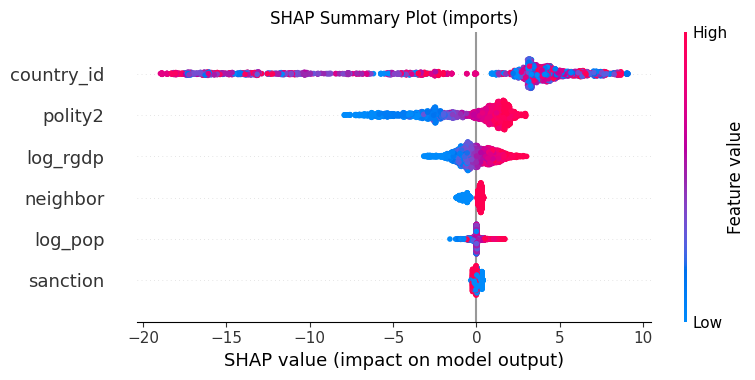

# EXPORT

In [44]:
# =========================================================
# 5️⃣ Run full workflow for exports
# =========================================================


# Prepare data for exports
X_cont_exp, X_country_exp, y_exp, le_exp, num_countries_exp, features_exp = prepare_data(df_sanction, target="log_exports")

# Run folds
df_folds_exp = []
for n in range(1, 6):
    df_fold_exp = run_fold_shap(n, X_cont_exp, X_country_exp, y_exp, num_countries_exp, features_exp, save_dir=result_path)
    df_folds_exp.append(df_fold_exp)

# Combine folds and save final exports file
exports_file = os.path.join(result_path, "results_exports.csv")
df_all_exports = combine_folds(df_folds_exp, exports_file)


Number of countries: 72

🔹 Running Fold 1


100%|██████████| 518/518 [01:32<00:00,  5.58it/s]


💾 Fold 1 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_1_results.csv

🔹 Running Fold 2


100%|██████████| 518/518 [01:33<00:00,  5.53it/s]


💾 Fold 2 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_2_results.csv

🔹 Running Fold 3


100%|██████████| 518/518 [01:35<00:00,  5.44it/s]


💾 Fold 3 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_3_results.csv

🔹 Running Fold 4


100%|██████████| 518/518 [01:35<00:00,  5.45it/s]


💾 Fold 4 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_4_results.csv

🔹 Running Fold 5


100%|██████████| 518/518 [01:34<00:00,  5.51it/s]


💾 Fold 5 results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/fold_5_results.csv

📂 Combined results saved to: /Users/tamhan/Library/CloudStorage/GoogleDrive-hantam171@iuj.ac.jp/My Drive/sanctions_project/result/results_exports.csv


# ML result


📊 Model Performance by Fold and Dataset:
   Fold Dataset        MSE      RMSE        R2
0     1   train  18.965250  4.354911  0.816661
1     1    test  15.298521  3.911332  0.853705
2     2   train  19.383018  4.402615  0.815366
3     2    test  21.216375  4.606123  0.783536
4     3   train  16.665930  4.082393  0.838088
5     3    test  22.547655  4.748437  0.788534
6     4   train  17.797966  4.218763  0.824664
7     4    test  15.464389  3.932479  0.861428
8     5   train  16.242451  4.030192  0.845939
9     5    test  20.574627  4.535926  0.786815

📈 Average Performance Across Folds:
             MSE    RMSE      R2
Dataset                         
test     19.0203  4.3469  0.8148
train    17.8109  4.2178  0.8281


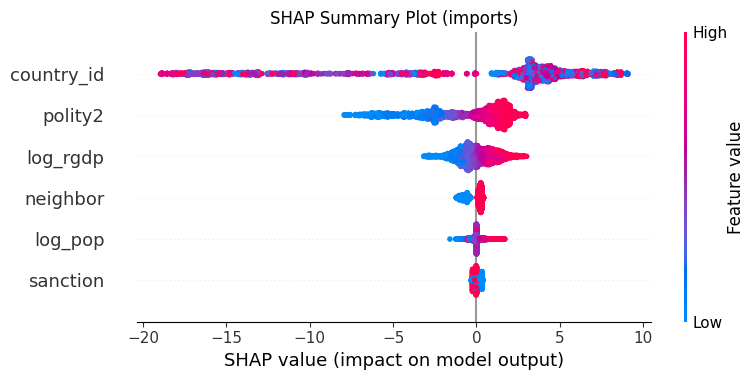

In [53]:
df_perf_imports = evaluate_model_performance(df_all_imports, target="imports")
# Example usage:
features = ["sanction", "neighbor", "log_rgdp", "log_pop", "polity2"]
plot_shap_summary(df_all_imports, features, target="imports")


📊 Model Performance by Fold and Dataset:
   Fold Dataset        MSE      RMSE        R2
0     1   train  18.965250  4.354911  0.816661
1     1    test  15.298521  3.911332  0.853705
2     2   train  19.383018  4.402615  0.815366
3     2    test  21.216375  4.606123  0.783536
4     3   train  16.665930  4.082393  0.838088
5     3    test  22.547655  4.748437  0.788534
6     4   train  17.797966  4.218763  0.824664
7     4    test  15.464389  3.932479  0.861428
8     5   train  16.242451  4.030192  0.845939
9     5    test  20.574627  4.535926  0.786815

📈 Average Performance Across Folds:
             MSE    RMSE      R2
Dataset                         
test     19.0203  4.3469  0.8148
train    17.8109  4.2178  0.8281


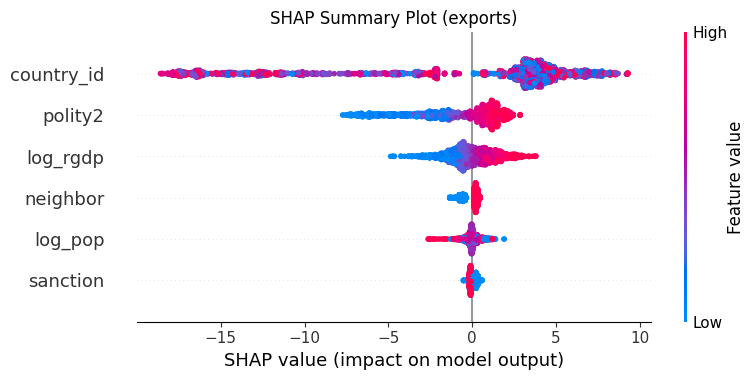

In [ ]:
df_perf_imports = evaluate_model_performance(df_all_imports, target="exports")
# Example usage:
features = ["sanction", "neighbor", "log_rgdp", "log_pop", "polity2"]
plot_shap_summary(df_all_exports, features, target="exports")

invalid value encountered in divide
invalid value encountered in divide


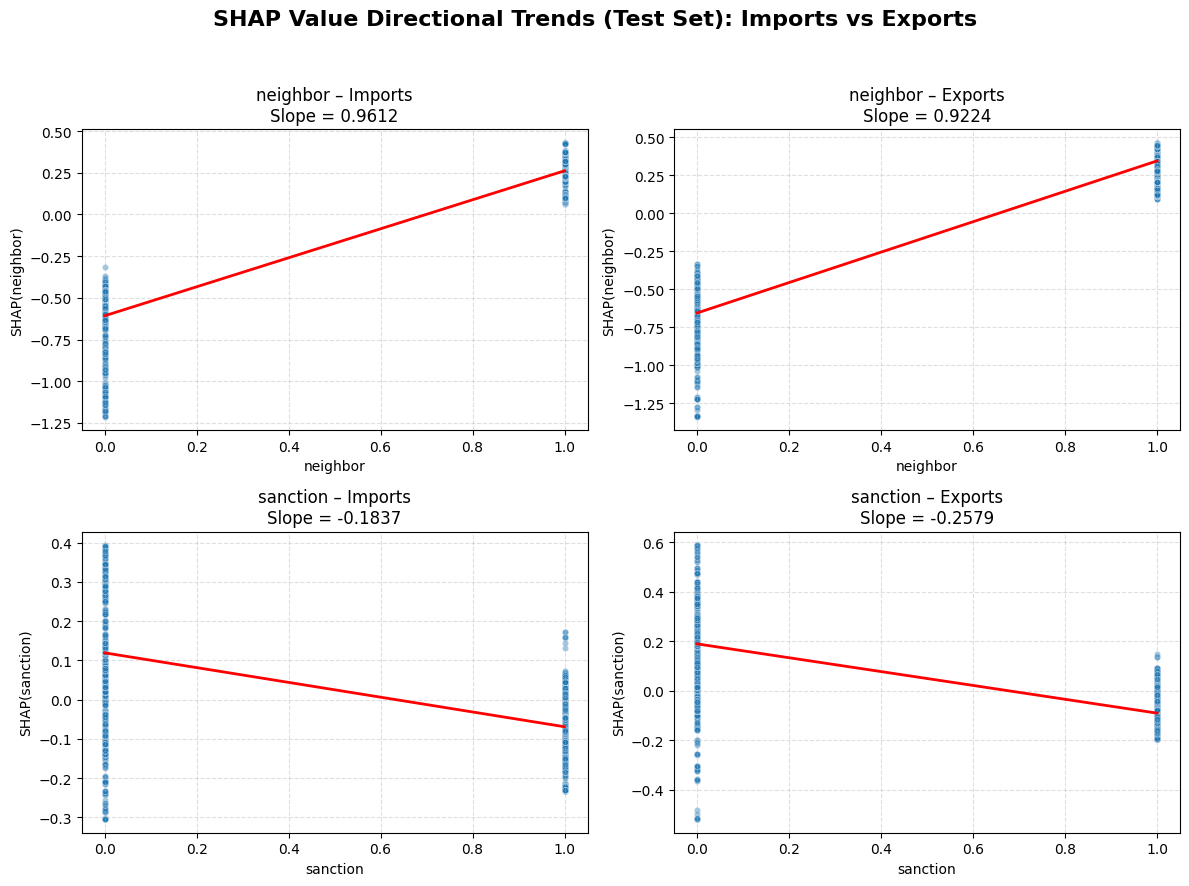

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

def shap_trend_comparison_test(df_imports, df_exports, features, dataset_col="dataset"):
    """
    Compare SHAP–feature directional trends across imports and exports.
    Only uses the test set.

    Parameters:
    -----------
    df_imports : pd.DataFrame
        DataFrame containing imports SHAP values.
    df_exports : pd.DataFrame
        DataFrame containing exports SHAP values.
    features : list of str
        Features to compare (must have corresponding shap_{feature} columns)
    dataset_col : str
        Column name indicating 'train' or 'test' (default='dataset')
    """
    # Filter only test set
    df_imports_test = df_imports[df_imports[dataset_col] == "test"].reset_index(drop=True)
    df_exports_test = df_exports[df_exports[dataset_col] == "test"].reset_index(drop=True)

    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle("SHAP Value Directional Trends (Test Set): Imports vs Exports",
                 fontsize=16, fontweight="bold")

    for i, feature in enumerate(features):
        for j, (df, outcome) in enumerate(zip([df_imports_test, df_exports_test], ["Imports", "Exports"])):
            shap_col = f"shap_{feature}"
            ax = axes[i, j]

            sns.scatterplot(
                x=feature,
                y=shap_col,
                data=df,
                alpha=0.4,
                s=20,
                ax=ax
            )

            # LOWESS trend line
            sns.regplot(
                x=feature,
                y=shap_col,
                data=df,
                lowess=True,
                scatter=False,
                line_kws={"color": "red", "lw": 2},
                ax=ax
            )

            # Numeric slope using linear regression
            X = sm.add_constant(df[feature])
            y = df[shap_col].fillna(0)
            slope = sm.OLS(y, X).fit().params[feature]

            ax.set_title(f"{feature} – {outcome}\nSlope = {slope:.4f}", fontsize=12)
            ax.set_xlabel(feature)
            ax.set_ylabel(f"SHAP({feature})")
            ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ================================
# Example usage
# ================================
features_to_show = ["neighbor", "sanction"]

# df_all_imports and df_all_exports should include:
# - 'neighbor', 'sanction', 'shap_neighbor', 'shap_sanction', 'dataset' columns
shap_trend_comparison_test(df_all_imports, df_all_exports, features_to_show)
